In [11]:
!pip install librosa

In [13]:
import librosa
from librosa.display import *
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
CREMA = "/content/Crema"

In [15]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [16]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020]

for i in dir_list:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

female_angry      166
female_disgust    166
female_fear       166
female_happy      166
female_sad        166
female_neutral    141
male_angry        111
male_disgust      111
male_fear         111
male_happy        111
male_sad          111
male_neutral       95
Name: labels, dtype: int64

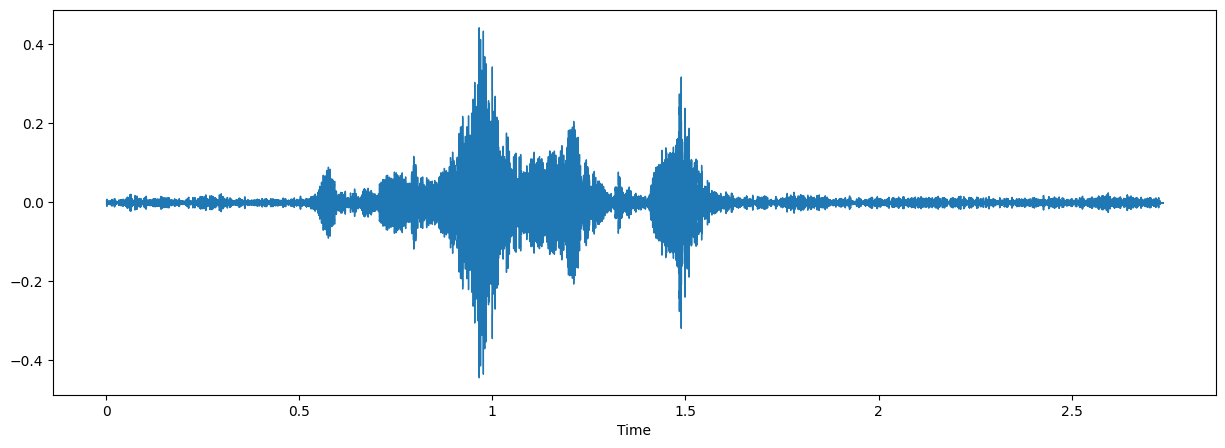

In [18]:
fname = '/content/Crema/1012_IEO_HAP_HI.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio
ipd.Audio(fname)

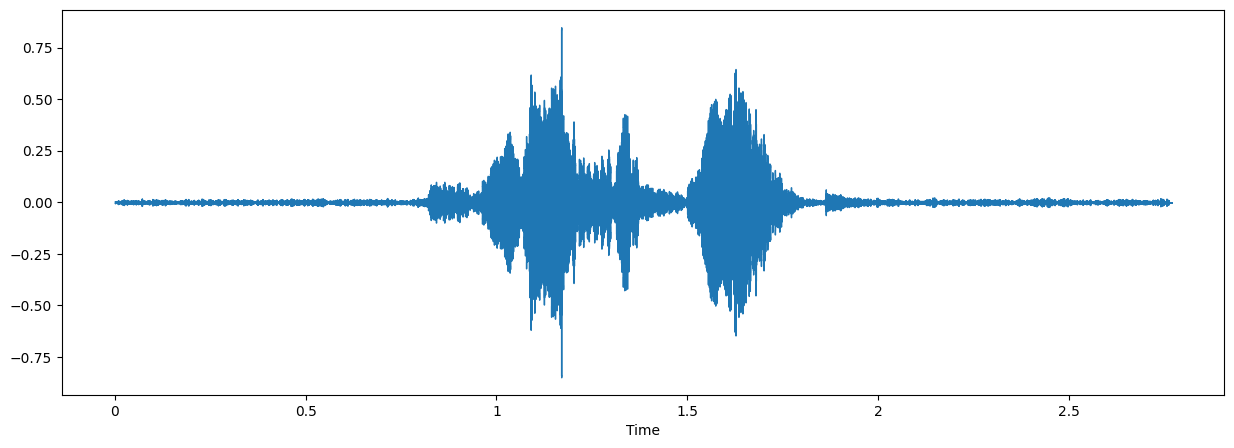

In [21]:
# A fearful track
fname = '/content/Crema/1012_IEO_FEA_HI.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio
ipd.Audio(fname)

In [22]:
df = pd.concat([CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("/content/Data_path.csv",index=False)

female_angry      166
female_disgust    166
female_fear       166
female_happy      166
female_sad        166
female_neutral    141
male_angry        111
male_disgust      111
male_fear         111
male_happy        111
male_sad          111
male_neutral       95
Name: labels, dtype: int64


In [33]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.0 MB/s eta 0:00:00


In [34]:
# Importing required libraries
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [35]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("/content/Data_path.csv")
ref.head()

,labels,source,path
0,male_angry,CREMA,/content/Crema/1001_DFA_ANG_XX.wav
1,male_disgust,CREMA,/content/Crema/1001_DFA_DIS_XX.wav
2,male_fear,CREMA,/content/Crema/1001_DFA_FEA_XX.wav
3,male_happy,CREMA,/content/Crema/1001_DFA_HAP_XX.wav
4,male_neutral,CREMA,/content/Crema/1001_DFA_NEU_XX.wav


In [39]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets
df = pd.DataFrame(columns=['features'])

# loop feature extraction over the entire dataset
counter=0

for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path)
    sample_rate = np.array(sample_rate)

    # mean as the feature. Could do min and max etc as well.
    mfccs = np.mean(librosa.feature.mfcc(y=X,
                                        sr=sample_rate,
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

1621


,features
0,"[-47.588882, -29.184845, -23.81415, -23.018381..."
1,"[-25.360691, -23.582808, -21.892937, -19.54212..."
2,"[-23.172516, -23.247349, -24.189016, -23.83220..."
3,"[-21.348787, -19.612019, -21.584219, -25.19538..."
4,"[-23.650738, -21.146597, -20.340878, -20.60482..."


In [41]:
df = pd.concat([ref,pd.DataFrame(df['features'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,CREMA,/content/Crema/1001_DFA_ANG_XX.wav,-47.588882,-29.184845,-23.814150,-23.018381,-23.318026,-21.501926,-21.099583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,male_disgust,CREMA,/content/Crema/1001_DFA_DIS_XX.wav,-25.360691,-23.582808,-21.892937,-19.542120,-19.785917,-21.775402,-21.783445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,male_fear,CREMA,/content/Crema/1001_DFA_FEA_XX.wav,-23.172516,-23.247349,-24.189016,-23.832201,-22.605062,-22.817146,-21.990183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,male_happy,CREMA,/content/Crema/1001_DFA_HAP_XX.wav,-21.348787,-19.612019,-21.584219,-25.195385,-23.193407,-21.178469,-21.584627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,male_neutral,CREMA,/content/Crema/1001_DFA_NEU_XX.wav,-23.650738,-21.146597,-20.340878,-20.604824,-21.733772,-21.209166,-21.185301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df=df.fillna(0)
print(df.shape)
df[:5]

(1621, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,CREMA,/content/Crema/1001_DFA_ANG_XX.wav,-47.588882,-29.184845,-23.814150,-23.018381,-23.318026,-21.501926,-21.099583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,male_disgust,CREMA,/content/Crema/1001_DFA_DIS_XX.wav,-25.360691,-23.582808,-21.892937,-19.542120,-19.785917,-21.775402,-21.783445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,male_fear,CREMA,/content/Crema/1001_DFA_FEA_XX.wav,-23.172516,-23.247349,-24.189016,-23.832201,-22.605062,-22.817146,-21.990183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,male_happy,CREMA,/content/Crema/1001_DFA_HAP_XX.wav,-21.348787,-19.612019,-21.584219,-25.195385,-23.193407,-21.178469,-21.584627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,male_neutral,CREMA,/content/Crema/1001_DFA_NEU_XX.wav,-23.650738,-21.146597,-20.340878,-20.604824,-21.733772,-21.209166,-21.185301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
282,-25.473156,-23.782982,-23.003349,-22.578114,-22.376884,-21.449471,-20.393070,-19.522419,-20.691643,-23.037222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
291,-23.760847,-22.852491,-22.181282,-21.953674,-22.113869,-22.559835,-23.974649,-21.817057,-19.993294,-20.206055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
802,-21.209141,-19.675743,-18.261003,-16.166775,-15.711080,-17.146629,-18.129347,-18.762493,-19.273687,-18.771313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576,-19.739536,-16.200716,-15.586665,-18.408308,-20.030964,-17.844484,-18.754845,-17.853693,-17.747507,-18.551008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,-20.781210,-21.807343,-22.621542,-23.019869,-22.152046,-22.648872,-23.057285,-21.417147,-20.396029,-19.609724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,-21.990988,-20.778999,-22.901176,-23.284147,-21.893908,-20.748991,-20.406595,-19.273190,-21.468260,-20.758148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
781,-20.913609,-18.362667,-18.186823,-18.760220,-18.924856,-18.463863,-19.709654,-18.784502,-19.463005,-19.186064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,-20.614653,-17.519026,-16.763157,-17.174343,-18.661079,-17.116585,-14.855671,-13.816544,-15.453653,-17.554733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1569,-19.395168,-16.964191,-15.547457,-17.526075,-16.565077,-16.936993,-18.710752,-19.890507,-18.252604,-17.669706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1434,-20.260511,-17.655565,-18.171082,-17.753201,-17.946815,-17.795017,-17.389570,-16.885141,-15.868337,-15.453095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Lts do data normalization
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
282,-0.933400,-1.995735,-1.848534,-1.687019,-1.608956,-1.237192,-0.766833,-0.430369,-0.934106,-1.829221,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701
291,-0.518536,-1.616093,-1.496362,-1.420181,-1.497707,-1.698604,-2.233810,-1.357442,-0.656872,-0.734379,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701
802,0.099702,-0.319972,0.183076,1.052697,1.210505,0.550853,0.160365,-0.123346,-0.371199,-0.179549,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701
576,0.455763,1.097847,1.328756,0.094837,-0.616693,0.260859,-0.095833,0.243825,0.234672,-0.094355,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701
129,0.203383,-1.189670,-1.684968,-1.875791,-1.513855,-1.735604,-1.858067,-1.195871,-0.816752,-0.503771,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701
323,-0.089727,-0.770103,-1.804763,-1.988724,-1.404669,-0.946108,-0.772373,-0.329676,-1.242412,-0.947879,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701
781,0.171305,0.215766,0.214855,-0.055543,-0.148838,0.003476,-0.486913,-0.132238,-0.446355,-0.339938,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701
1004,0.243737,0.559974,0.824750,0.622140,-0.037267,0.563338,1.501228,1.874903,1.145298,0.290915,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701
1569,0.539198,0.786347,1.345553,0.471836,0.849287,0.637967,-0.077773,-0.579083,0.034156,0.246454,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701
1434,0.329540,0.504265,0.221599,0.374780,0.264848,0.281415,0.463369,0.635137,0.980674,1.103640,...,0.049648,0.049583,0.049476,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701,0.028701


In [45]:
# Lets few preparation steps to get it into the correct format for Keras
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(1215, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'male_angry' 'male_disgust' 'male_fear'
 'male_happy' 'male_neutral' 'male_sad']


In [46]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1215, 216, 1)

In [67]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [69]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())

model.add(Dense(12, activation='linear')) # Target class number
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = keras.optimizers.Adam(lr=0.0001)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 216, 256)          2304      
                                                                 
 activation_34 (Activation)  (None, 216, 256)          0         
                                                                 
 conv1d_33 (Conv1D)          (None, 216, 256)          524544    
                                                                 
 batch_normalization_8 (Bat  (None, 216, 256)          1024      
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 216, 256)          0         
                                                                 
 dropout_8 (Dropout)         (None, 216, 256)          0         
                                                      

In [70]:
print("Shape of x_test:", X_test.shape)
print("Shape of x_train:", X_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_train:", y_train.shape)

Shape of x_test: (406, 216, 1)
Shape of x_train: (1215, 216, 1)
Shape of y_test: (406, 12)
Shape of y_train: (1215, 12)


In [74]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
76/76 [==============================] - 33s 404ms/step - loss: 8.3177 - accuracy: 0.1070 - val_loss: 7.4636 - val_accuracy: 0.0887
Epoch 2/100
76/76 [==============================] - 33s 437ms/step - loss: 8.3177 - accuracy: 0.1070 - val_loss: 7.4636 - val_accuracy: 0.0887
Epoch 3/100
76/76 [==============================] - 30s 399ms/step - loss: 8.3177 - accuracy: 0.1070 - val_loss: 7.4636 - val_accuracy: 0.0887
Epoch 4/100
76/76 [==============================] - 31s 402ms/step - loss: 8.3177 - accuracy: 0.1070 - val_loss: 7.4636 - val_accuracy: 0.0887
Epoch 5/100
76/76 [==============================] - 33s 436ms/step - loss: 7.8826 - accuracy: 0.0897 - val_loss: 7.4636 - val_accuracy: 0.0788
Epoch 6/100
76/76 [==============================] - 30s 402ms/step - loss: 8.3177 - accuracy: 0.0840 - val_loss: 7.2254 - val_accuracy: 0.0837
Epoch 7/100
76/76 [==============================] - 34s 436ms/step - loss: 8.2779 - accuracy: 0.0889 - val_loss: 7.2254 - val_accuracy:

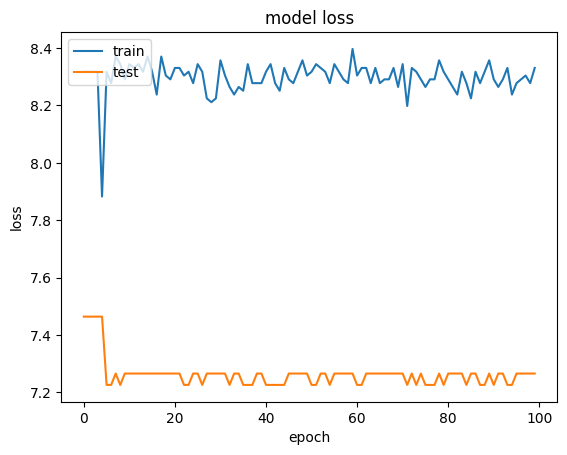

In [75]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model.h5 


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
# loading json and model architecture
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")

# Keras optimiser
opt = keras.optimizers.Adam(lr=0.00001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 8.62%


In [81]:
preds = loaded_model.predict(X_test,
                         batch_size=16,
                         verbose=1)

preds=preds.argmax(axis=1)
preds

26/26 [==============================] - 2s 79ms/step


array([5, 8, 8, 7, 8, 7, 8, 7, 8, 8, 8, 8, 8, 7, 8, 5, 8, 8, 8, 5, 7, 7,
       5, 8, 7, 5, 8, 8, 7, 5, 8, 7, 7, 8, 7, 7, 8, 8, 8, 5, 8, 8, 7, 8,
       8, 8, 7, 8, 8, 5, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 7, 8, 8, 5, 8,
       8, 8, 8, 5, 7, 8, 8, 7, 8, 8, 5, 8, 8, 5, 8, 8, 8, 8, 8, 8, 5, 8,
       8, 8, 8, 8, 7, 8, 8, 8, 7, 7, 7, 8, 5, 8, 8, 7, 8, 8, 8, 8, 8, 8,
       7, 8, 8, 8, 7, 7, 8, 8, 8, 7, 8, 8, 7, 8, 7, 8, 8, 8, 5, 8, 5, 8,
       7, 8, 8, 7, 7, 7, 5, 8, 8, 8, 8, 7, 8, 5, 7, 5, 7, 8, 7, 8, 7, 7,
       7, 8, 7, 7, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 5, 5, 8, 5, 8, 8, 7, 8, 5, 8, 8, 8, 7, 8, 8, 8, 7, 8, 7, 8,
       8, 8, 8, 7, 7, 8, 8, 8, 8, 8, 7, 8, 7, 8, 8, 5, 7, 8, 8, 7, 8, 5,
       8, 7, 8, 8, 7, 8, 8, 8, 5, 5, 7, 8, 5, 8, 7, 7, 8, 8, 8, 8, 7, 7,
       7, 8, 7, 8, 8, 5, 7, 8, 8, 8, 5, 8, 8, 7, 7, 7, 7, 5, 7, 8, 8, 7,
       8, 8, 8, 7, 8, 8, 7, 8, 8, 8, 7, 8, 5, 8, 8, 8, 8, 8, 8, 8, 5, 8,
       5, 8, 7, 7, 8, 5, 8, 8, 8, 8, 7, 7, 7, 5, 5,

In [82]:
# predictions
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_fear,male_fear
171,male_neutral,male_fear
172,female_neutral,male_fear
173,male_fear,male_fear
174,male_sad,male_fear
175,male_angry,male_fear
176,male_neutral,male_fear
177,female_happy,male_fear
178,male_angry,female_sad
179,female_disgust,female_sad


In [83]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_sad,56
male_disgust,102
male_fear,248


In [84]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.08620689655172414


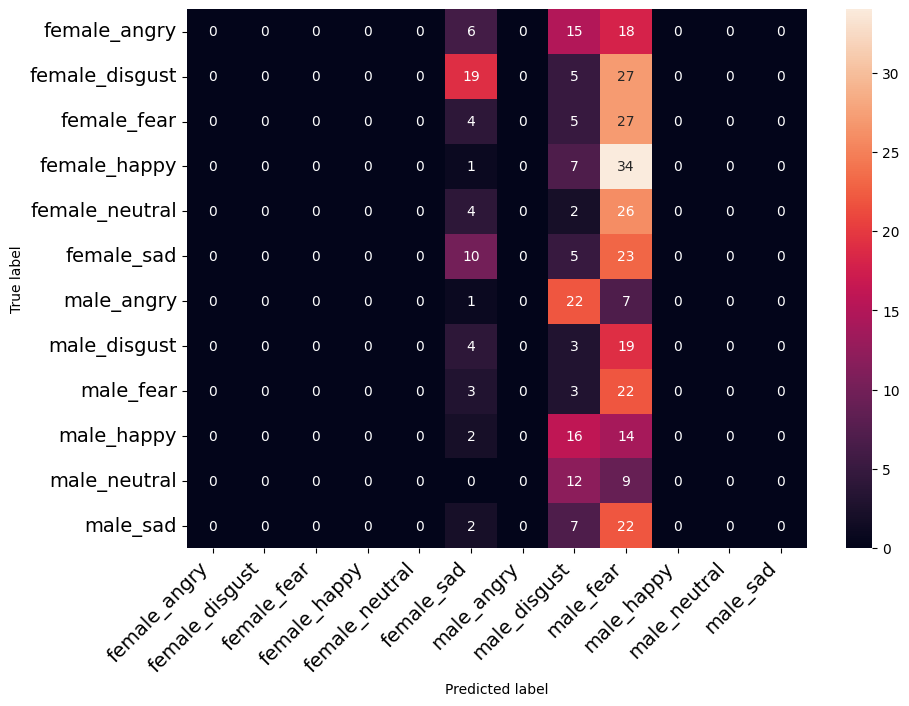

In [85]:
# Get the predictions file
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [86]:
# Classification report
classes = finaldf.actualvalues.unique()
classes.sort()
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                precision    recall  f1-score   support

  female_angry       0.00      0.00      0.00        39
female_disgust       0.00      0.00      0.00        51
   female_fear       0.00      0.00      0.00        36
  female_happy       0.00      0.00      0.00        42
female_neutral       0.00      0.00      0.00        32
    female_sad       0.18      0.26      0.21        38
    male_angry       0.00      0.00      0.00        30
  male_disgust       0.03      0.12      0.05        26
     male_fear       0.09      0.79      0.16        28
    male_happy       0.00      0.00      0.00        32
  male_neutral       0.00      0.00      0.00        21
      male_sad       0.00      0.00      0.00        31

      accuracy                           0.09       406
     macro avg       0.02      0.10      0.03       406
  weighted avg       0.02      0.09      0.03       406



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.49261083743842365


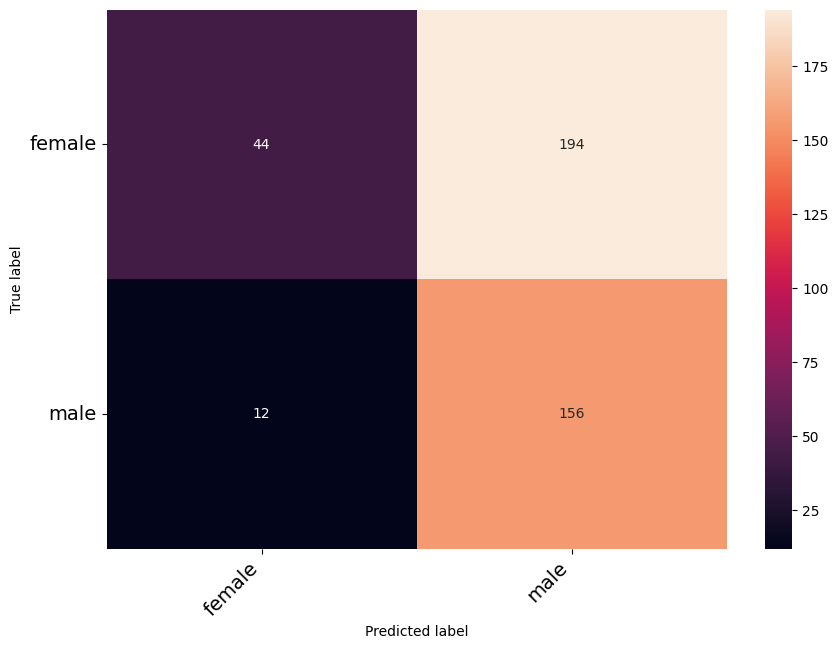

In [87]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [88]:
# Classification report
classes = modidf.actualvalues.unique()
classes.sort()
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.79      0.18      0.30       238
        male       0.45      0.93      0.60       168

    accuracy                           0.49       406
   macro avg       0.62      0.56      0.45       406
weighted avg       0.65      0.49      0.42       406



0.16995073891625614


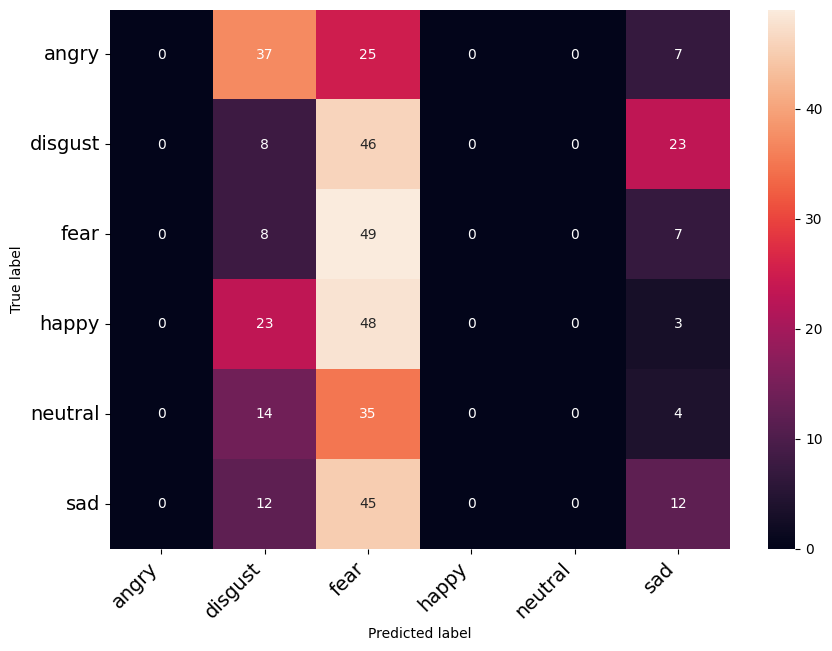

In [89]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [90]:
# Classification report
classes = modidf.actualvalues.unique()
classes.sort()
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        69
     disgust       0.08      0.10      0.09        77
        fear       0.20      0.77      0.31        64
       happy       0.00      0.00      0.00        74
     neutral       0.00      0.00      0.00        53
         sad       0.21      0.17      0.19        69

    accuracy                           0.17       406
   macro avg       0.08      0.17      0.10       406
weighted avg       0.08      0.17      0.10       406



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
data, sampling_rate = librosa.load('/content/Crema/1006_DFA_HAP_XX.wav')
ipd.Audio('/content/Crema/1006_DFA_HAP_XX.wav')

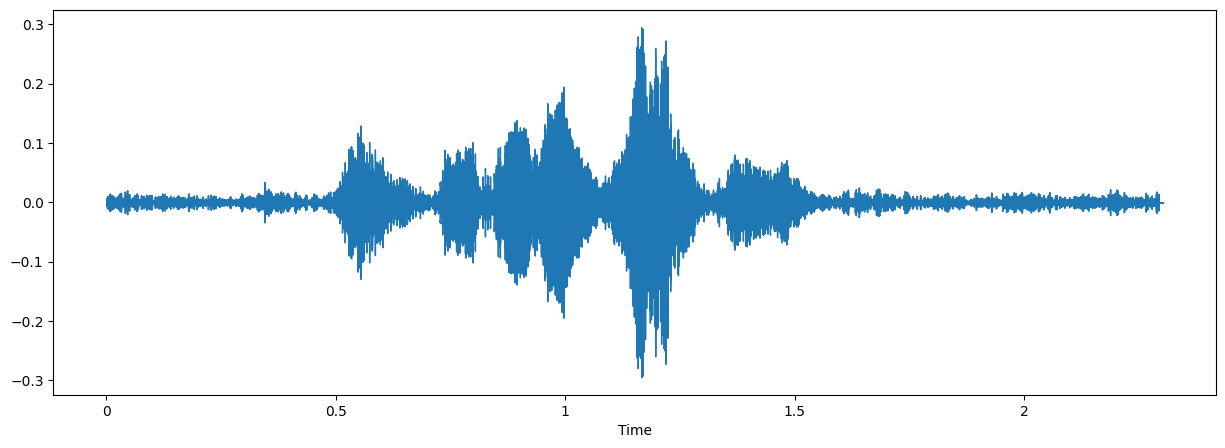

In [93]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)